In [1]:
#Import des librairies nécessaires
import numpy as np
import cv2

In [2]:
# Fonction qui définit la distance quadratique entre deux "patches"
dist = lambda a, b, k : np.linalg.norm(a - b)**2 / (k**2)

In [3]:
def parameters_value(sigma):
    if 0 <= sigma < 20:
        k1 = 3  #size of patches
        k2 = 3
        gamma = 1.05
        Beta1 = 1.0  # coeﬃcient used during the collaborative ﬁlterin
        Beta2 = 1.2
        n1 = 21   #  search window size
        n2 = 21
        N1 = 30   # maximum number of similar patches kept
        N2 = 30
        tau0 = 4 # minimum threshold to determine similar patches during the second step
    if 20 <= sigma < 50:
        k1 = 5
        k2 = 3
        gamma = 1.05
        Beta1 = 1.0
        Beta2 = 1.2
        n1 = 35
        n2 = 21
        N1 = 60
        N2 = 30
        tau0 = 4
    if 50 <= sigma < 70:
        k1 = 7
        k2 = 5
        gamma = 1.05
        Beta1 = 1.0
        Beta2 = 1.0
        n1 = 49
        n2 = 35
        N1 = 90
        N2 = 60
        tau0 = 4
    if sigma >= 70:
        k1 = 7
        k2 = 7
        gamma = 1.05
        Beta1 = 1.0
        Beta2 = 1.0
        n1 = 49
        n2 = 49
        N1 = 90
        N2 = 90
        tau0 = 4
    return k1, k2, gamma, Beta1, Beta2, n1, n2, N1, N2, tau0



In [4]:
# Selectionne la zone de recherche
def select_search_zone(u_noised, row, column, n_rows, n_columns, lambda_):
    row_min = 0 if row - lambda_//2 < 0 else row - lambda_//2
    row_max = n_rows if row + lambda_//2 + lambda_%2 > n_rows else row + lambda_//2 + lambda_%2
    column_min = 0 if column - lambda_//2 < 0 else column - lambda_//2
    column_max = n_columns if column + lambda_//2 + lambda_%2 > n_columns else column + lambda_//2 + lambda_%2
    
    if column_min == 0:
        column_max = lambda_
    if column_max == n_columns: 
        column_min = column_max - lambda_
    if row_min == 0:
        row_max = lambda_
    if row_max == n_columns: 
        row_min = row_max - lambda_
    return u_noised[row_min : row_max, column_min : column_max]

In [5]:
from math import sqrt
from numpy.linalg import inv

def NL_BAYES_first_part(u_noised, sigma, k_grid = 0, N_grid = 0, n_grid = 0, gamma_grid = 0, tau_grid = 0, beta_grid= 0, grid = False ):

    n_rows, n_columns = u_noised.shape
    
    V = np.zeros((u_noised.shape[0], u_noised.shape[1]))
    DELTA = np.zeros((u_noised.shape[0], u_noised.shape[1]))
    u_basic = np.zeros((u_noised.shape[0], u_noised.shape[1]))
    
    k1, _, gamma, Beta1, _, n1, _, N1, _, _ = parameters_value(sigma)
    
    if grid ==True:
        k1 = k_grid
        N1 = N_grid 
        Beta1 = beta_grid 
        n1 = n_grid
        gamma = gamma_grid
    
    for row in range(k1//2, n_rows - k1//2 - k1%2 + 1):
        for column in range(k1//2, n_columns - k1//2 - k1%2 + 1):
            P = u_noised[row - k1//2 : row + k1//2 + k1%2, column - k1//2 : column + k1//2 + k1%2]

            # Grouping
            search_zone = select_search_zone(u_noised, row, column, n_rows, n_columns, n1)
            L = []
            for i in range(search_zone.shape[0] - k1 + 1):
                for j in range(search_zone.shape[1] - k1 + 1):
                    Q = search_zone[i : i  + k1, j : j + k1]
                    dist_ = dist(P,Q,k1)
                    L.append((Q, dist_))
            L.sort(key = lambda x : x[1])
            group_3D = np.array(L[:N1])[:,0]  
                
            # Collaborative Filtering
            M1=N1*(k1**2)
            sum_1=np.sum([np.sum(Q**2) for Q in group_3D])
            sum_2=np.sum([np.sum(Q) for Q in group_3D])
            #print('sum_1:', sum_1)
            #print('sum_2:', sum_2)
            std_P_2=(M1/(M1-1))*(((1/M1)*sum_1)-((1/M1)*sum_2)**2)
            std_P = sqrt(std_P_2)
            #print('std P:', std_P)
            group_3D_basic=[]
            
            if std_P<=(gamma*sigma):
                for Q in group_3D:
                    Q_basic=np.ones((k1,k1))*(1/M1)*sum_2
                    group_3D_basic.append(Q_basic)
            else:
                P_estimate=(1/N1)*np.sum(Q for Q in group_3D)
                #print(P_estimate.shape)
                QP_estimate=[(Q-P_estimate)*(Q-P_estimate).T for Q in group_3D]
                Cp=(1/(N1-1))*np.sum(QP_estimate[i] for i in range(len(QP_estimate)))
                #print(Cp.shape)
                
                I=np.identity(k1)
                sigma_2=sigma**2
                inv_Cp=inv(Cp)
                
                for Q in group_3D:
                    try:
                        Q_basic=P_estimate+(Cp-Beta1*sigma_2*I)*inv_Cp*(Q-P_estimate)
                    except ValueError:
                        Q_basic=Q
                    group_3D_basic.append(Q_basic)
                        
                
            # Aggregation
            for Q_basic in group_3D_basic:
                for i in range(Q_basic.shape[0]):
                    for j in range(Q_basic.shape[1]):
                        V[row - k1//2 + i, column - k1//2 + j] += Q_basic[i, j]
                        DELTA[row - k1//2 + i, column - k1//2 + j] += 1.0
            
    u_basic = (V / DELTA)
    
    return u_basic

In [11]:
# La seconde étape de débruitage
def NL_BAYES_second_part(u_noised, u_basic, sigma, k_grid=0, N_grid=0, beta_grid=0, n_grid=0, tau_grid=0,   grid = False ):
    
    n_rows, n_columns = u_noised.shape
    
    V = np.zeros((u_noised.shape[0], u_noised.shape[1]))
    DELTA = np.zeros((u_noised.shape[0], u_noised.shape[1]))
    u_denoised = np.zeros((u_noised.shape[0], u_noised.shape[1]))
    
    _, k2, _, _, Beta2, _, n2, _, N2, tau0 = parameters_value(sigma)
    
    if grid ==True:
        k2 = k_grid
        N2 = N_grid 
        Beta2 = beta_grid 
        n2 = n_grid
        tau0 = tau_grid
    
    for row in range(k2//2, n_rows - k2//2 - k2%2 + 1):
        for column in range(k2//2, n_columns - k2//2 - k2%2 + 1):
            P = u_noised[row - k2//2 : row + k2//2 + k2%2, column - k2//2 : column + k2//2 + k2%2]
            P_basic = u_basic[row - k2//2 : row + k2//2 + k2%2, column - k2//2 : column + k2//2 + k2%2]

            # Grouping
            search_zone_basic = select_search_zone(u_basic, row, column, n_rows, n_columns, n2)
            search_zone = select_search_zone(u_noised, row, column, n_rows, n_columns, n2)
            L_basic = []
            L = []
            
            for i in range(search_zone_basic.shape[0] - k2 + 1):
                for j in range(search_zone_basic.shape[1] - k2 + 1):
                    Q_basic = search_zone_basic[i : i  + k2, j : j + k2]
                    dist_ = dist(P_basic,Q_basic,k2)
                    L_basic.append((Q_basic, dist_))
                    Q = search_zone[i : i  + k2, j : j + k2]
                    L.append((Q, dist_))
            L_basic.sort(key = lambda x : x[1])
            L.sort(key = lambda x : x[1])
            
            dN2=L[N2][1]
            tau=max(tau0,dN2)
            group_3D_basic = []
            group_3D = []
            for i in range(len(L)):
                dist_Pbasic_Qbasic=L[i][1]
                if dist_Pbasic_Qbasic<tau:
                    group_3D_basic.append(L_basic[i][0])  
                    group_3D.append(L[i][0])

            #Collaborative Filtering
            P_basic_estimate=(1/len(group_3D))*np.sum(Q for Q in group_3D)
            Qbasic_Pbasic_estimate=[(Q_basic-P_basic_estimate)*(Q_basic-P_basic_estimate).T for Q_basic in group_3D_basic]
         
            Cp_basic=(1/(len(group_3D_basic)-1))*np.sum(Qbasic_Pbasic_estimate[i] for i in range(len(Qbasic_Pbasic_estimate)))
                
            I=np.identity(k2)
            sigma_2=sigma**2
                
            group_3D_final=[]
            for Q in group_3D:
                Q_final=P_basic_estimate+Cp_basic*inv(Cp_basic+Beta2*sigma_2*I)*(Q-P_basic_estimate)
                group_3D_final.append(Q_final)
            
            #Aggregation
            for Q_final in group_3D_final:
                for i in range(Q_final.shape[0]):
                    for j in range(Q_final.shape[1]):
                        V[row - k2//2 + i, column - k2//2 + j] += Q_final[i,j]
                        DELTA[row - k2//2 + i, column - k2//2 + j] += 1
            
    u_final = (V / DELTA)
    
    return u_final

In [7]:
# L'algorithme général
def NL_BAYES(u_noised, sigma):
    
    u_basic = NL_BAYES_first_part(u_noised, sigma)
    u_denoised = NL_BAYES_second_part(u_noised, u_basic, sigma)
    
    return u_denoised

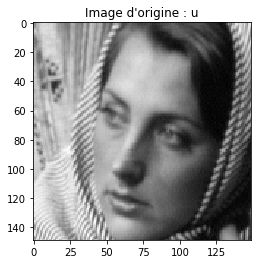

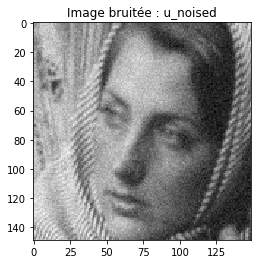

In [8]:
import matplotlib.pyplot as plt

# On importe u une image sans bruit
u = (plt.imread("barbara.png") * 255).astype(int)[25:174, 300:449]
plt.imshow(u, plt.cm.gray)
plt.title("Image d'origine : u")
plt.show()

u_shape = u.shape

# On crée artificiellement du bruit avec un écart-type de 5 (sigma = 5)
np_round = np.vectorize(lambda x : int(round(x,0)))
u_noised = u + np_round(np.random.normal(0, 10, ((u.shape[0], u.shape[1]))))
plt.imshow(u_noised, plt.cm.gray)
plt.title("Image bruitée : u_noised")
plt.show()

D:\Programmes\Anaconda2\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
D:\Programmes\Anaconda2\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


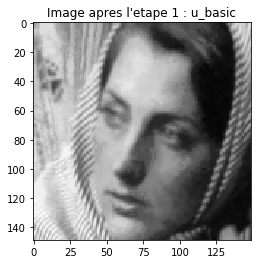

In [9]:
u_basic = NL_BAYES_first_part(u_noised, 10) # sigma = 10 car l'écart-type = 10

plt.imshow(u_basic, plt.cm.gray)
plt.title("Image apres l'etape 1 : u_basic")
plt.show()

D:\Programmes\Anaconda2\lib\site-packages\ipykernel_launcher.py:51: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
D:\Programmes\Anaconda2\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


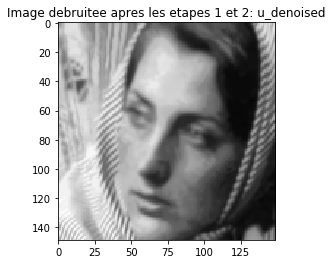

In [12]:
u_denoised = NL_BAYES_second_part(u_noised, u_basic, 10) # sigma = 10 car l'écart-type = 10

plt.imshow(u_denoised, plt.cm.gray)
plt.title("Image debruitee apres les etapes 1 et 2: u_denoised")
plt.show()

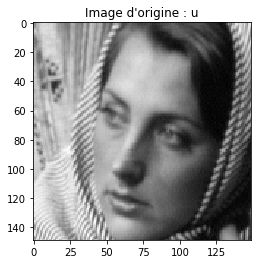

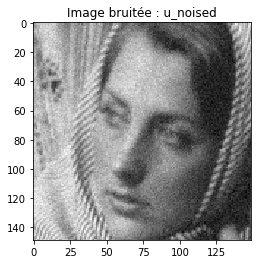

D:\Programmes\Anaconda2\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
D:\Programmes\Anaconda2\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
D:\Programmes\Anaconda2\lib\site-packages\ipykernel_launcher.py:51: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
D:\Programmes\Anaconda2\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


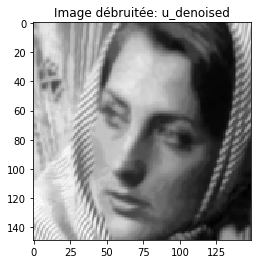

In [13]:
u = (plt.imread("barbara.png") * 255).astype(int)[25:174, 300:449]
plt.imshow(u, plt.cm.gray)
plt.title("Image d'origine : u")
plt.show()

u_noised = u + np_round(np.random.normal(0, 10, ((u.shape[0], u.shape[1]))))
plt.imshow(u_noised, plt.cm.gray)
plt.title("Image bruitée : u_noised")
plt.show()

u_denoised = NL_BAYES(u_noised, 10)

plt.imshow(u_denoised, plt.cm.gray)
plt.title("Image débruitée: u_denoised")
plt.show()


### III ) Experimentation 

#### Métriques de comparaison 


In [14]:
#https://www.researchgate.net/profile/Nirvair_Neeru/publication/271156596_Performance_Comparison_of_Various_Image_Denoising_Filters_under_Spatial_Domain/links/577f554e08ae5f367d3553ad/Performance-Comparison-of-Various-Image-Denoising-Filters-under-Spatial-Domain.pdf
import numpy 
import math
import cv2

def mse(img1, img2):
    D = numpy.array(img1 - img2, dtype=numpy.int64)
    D[:, :] = D[:, :]**2
    RMSE = D.sum()/img1.size
    return RMSE


def psnr(img1, img2):
    D = numpy.array(img1 - img2, dtype=numpy.int64)
    D[:, :] = D[:, :]**2
    RMSE = D.sum()/img1.size
    psnr = 10*math.log10(float(255.**2)/RMSE)
    return psnr

In [15]:
def print_experiment(u, u_noised, u_denoised):
    original =  u  #cv2.imread("original.png")
    noised = u_noised #cv2.imread("photoshopped.png",1)
    denoised = u_denoised
    psnr_ori_noised =psnr(original,noised)
    psnr_ori_denoised = psnr(original,denoised)
    psnr_noised_denoised = psnr(u_noised,denoised)
    mse_ori_noised = mse(original,noised)
    mse_ori_denoised = mse(original,denoised)
    mse_noised_denoised=  mse(u_noised,denoised)
    print("PSNR entre image originale et bruitée: ", psnr_ori_noised)
    print("PSNR entre image originale et débruitée: ", psnr_ori_denoised)
    #print("PSNR entre image bruitée et débruitée: ", psnr_noised_denoised)
    #print("MSE entre image originale et bruitée: ", mse_ori_noised)
    #print("MSE entre image originale et débruitée: ", mse_ori_denoised)
    #print("MSE entre image bruitée et débruitée: ", mse_noised_denoised)

def plot_image(u, u_noised, u_denoised):
    plt.imshow(u, plt.cm.gray)
    plt.title("Image d'origine : u")
    plt.show()
    plt.imshow(u_noised, plt.cm.gray)
    plt.title("Image bruitée : u_noised")
    plt.show()
    plt.imshow(u_denoised, plt.cm.gray)
    plt.title("Image débruitée: u_denoised")
    plt.show()


In [16]:
print_experiment(u, u_noised, u_denoised)

PSNR entre image originale et bruitée:  28.17910159225329
PSNR entre image originale et débruitée:  33.085653867703925


# Test de différents bruits avec NL Bayes 

The input images are corrupted by a simulated Gaussian white
noise (mean=0, variance=0.01), Salt & Pepper noise (noise
density= 0.05), Speckle noise (mean=0, variance=0.04),
Poisson noise, Uniform noise (interval [0,1]), Rayleigh noise
(parameters 0,1), Erlang noise (parameters 2,5). 

#### Bruit Gaussien ou Amplifier Noise
It is also known as Gaussian distribution. It has a probability
density function (PDF) of the normal distribution. This noise is
added to image during image acquisition like sensor noise
caused by low light, high temperature, transmission e.g.
electronic circuit noise [7]. This noise can be removed by using
spatial filtering (mean filtering, median filtering and gaussian
smoothing) by smoothing the image but smoothing also blurs
the fine-scaled image edges and details. 

In [17]:
import warnings
warnings.filterwarnings('ignore')

PSNR entre image originale et bruitée:  28.44345914479107
PSNR entre image originale et débruitée:  33.06632067870025


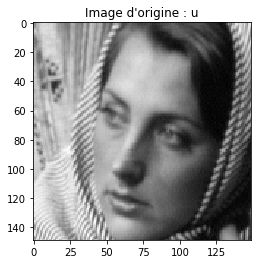

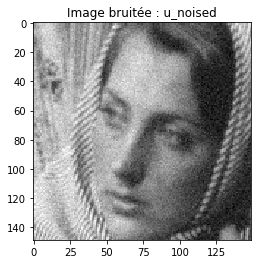

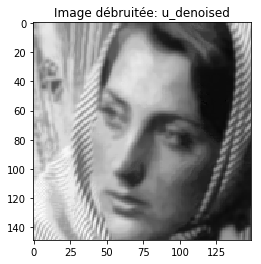

In [18]:

u_noised_gauss =  u + np.random.normal(0,10,(u.shape))
u_gauss_denoised = NL_BAYES(u_noised_gauss,10)
print_experiment(u, u_noised_gauss , u_gauss_denoised)
plot_image(u, u_noised_gauss, u_gauss_denoised)
    

PSNR entre image originale et bruitée:  5.806206185679788
PSNR entre image originale et débruitée:  5.806206185679788


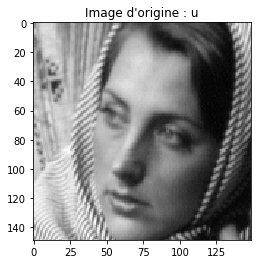

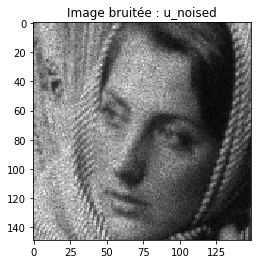

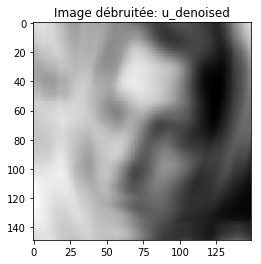

In [19]:
# Speckle 
import skimage
from skimage.util import random_noise
speckle_im = random_noise(u, mode='speckle', seed=None, clip=True)
u_speckle_denoised = NL_BAYES(speckle_im, 0.1)
print_experiment(u, speckle_im, u_speckle_denoised)
plot_image(u, speckle_im, u_speckle_denoised)

PSNR entre image originale et bruitée:  25.43006687854295
PSNR entre image originale et débruitée:  25.479092909812444


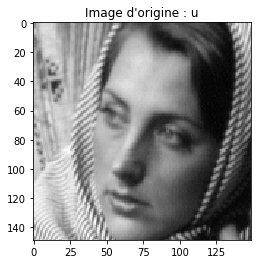

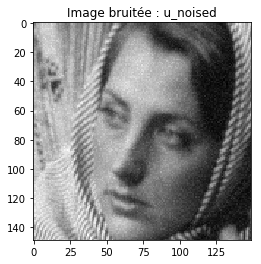

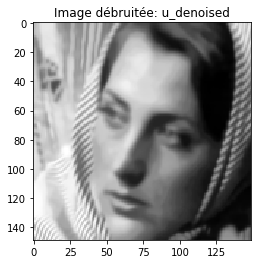

In [20]:
u_noised_rayleigh =  u + np.random.rayleigh(10, (u.shape))
u_rayleigh_denoised = NL_BAYES(u_noised_rayleigh,10)
print_experiment(u, u_noised_rayleigh , u_rayleigh_denoised)
plot_image(u, u_noised_rayleigh, u_rayleigh_denoised)

In [19]:
# Resultats bruit gaussien 
list_sigma = [2,5,10,20,30,40,60,80,100]
def result_exp(list_sigma, img):
    res_psnr = []
    res_mse =[]
    
    for sigma in list_sigma:
        img_gauss =  img + np.random.normal(0,sigma,(img.shape))
        
        # replace extreme value due to noise 
        img_gauss[img_gauss < 0] = 0
        img_gauss[img_gauss>255] = 255
        #print(img_gauss)
        img_gauss_denoised = NL_BAYES(img_gauss,sigma)
        psnr_before_denoising = psnr(img,img_gauss)
        mse_before_denosing = mse(img,img_gauss)
        psnr_after_denoising = psnr(img,img_gauss_denoised)
        mse_after_denosing = mse(img,img_gauss_denoised)
        
        # premier sans débruitage, deuxieme avec 
        res_psnr.append((psnr_before_denoising,psnr_after_denoising ))
        res_mse.append((mse_before_denosing,mse_after_denosing ))
        #if sigma == 2 or sigma == 30 or sigma == 100:
        print("sigma = " , sigma )

        plot_image(img, img_gauss, img_gauss_denoised)
            
    return res_psnr, res_mse
      

sigma =  2


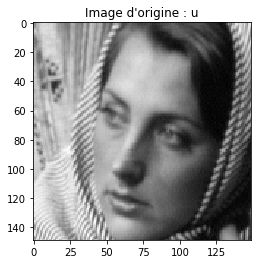

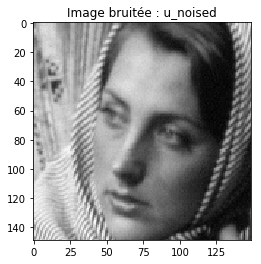

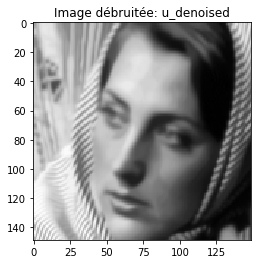

sigma =  5


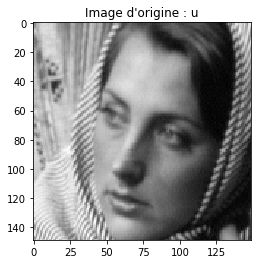

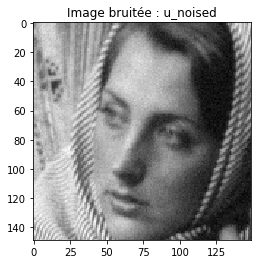

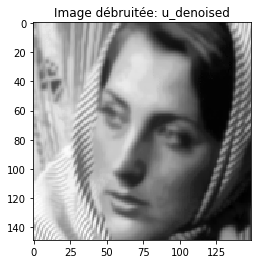

sigma =  10


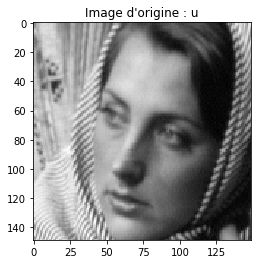

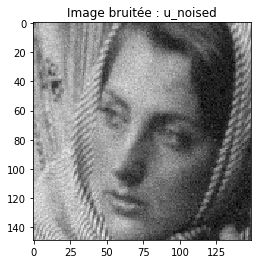

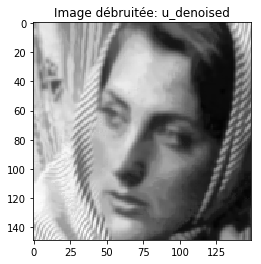

sigma =  20


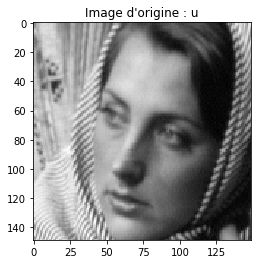

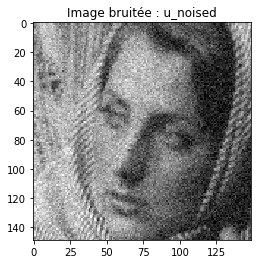

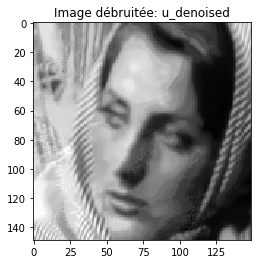

sigma =  30


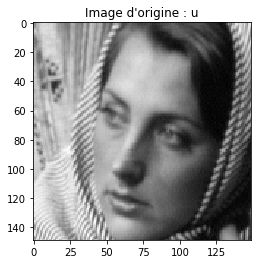

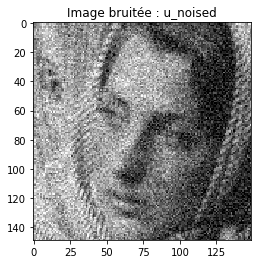

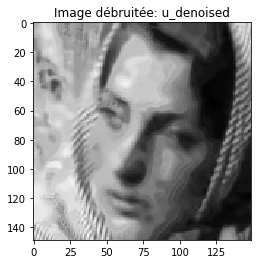

sigma =  40


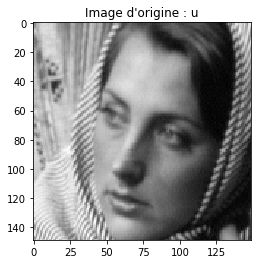

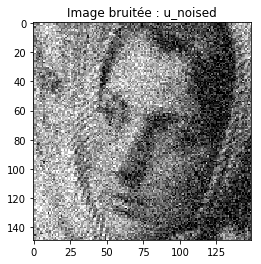

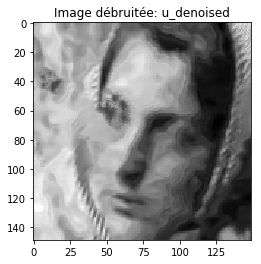

sigma =  60


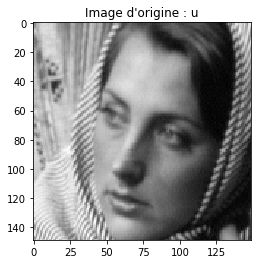

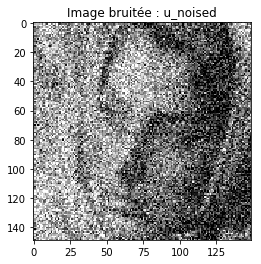

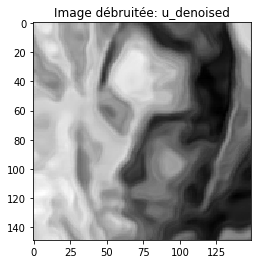

sigma =  80


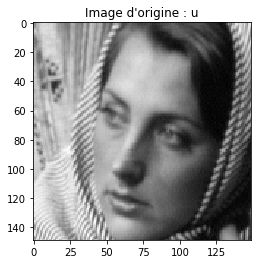

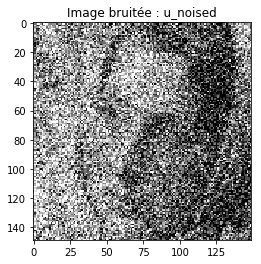

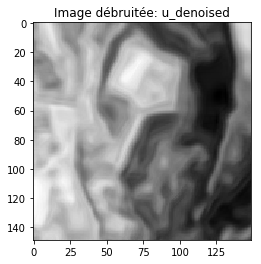

sigma =  100


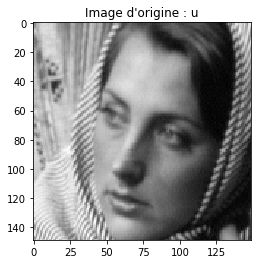

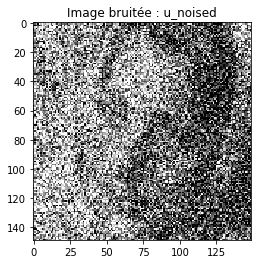

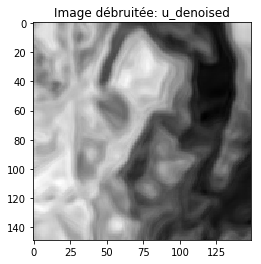

In [20]:
res_psnr, res_mse = result_exp(list_sigma, u)

In [21]:
res_psnr

[(43.781931167670436, 34.04839325764149),
 (34.79450259361903, 33.82557123657173),
 (28.391765505103095, 32.986251633625855),
 (22.301466476914527, 30.50252456141182),
 (18.886891903030477, 28.474777087832372),
 (16.543016436343855, 26.395678327122344),
 (13.405797146903968, 24.26167417953114),
 (11.527070374645694, 23.070040743427306),
 (10.370324935807139, 21.9300257340273)]

In [22]:
res_mse

[(2.7219945047520384, 25.600063060222514),
 (21.559073915589387, 26.947795144362868),
 (94.16810053601189, 32.69303184541237),
 (382.7663168325751, 57.91991351740913),
 (840.2164316922662, 92.3852529165353),
 (1441.3807486149271, 149.11197693797575),
 (2968.251159857664, 243.7322192694023),
 (4574.812756182154, 320.68325751092294),
 (5971.010945452907, 416.9440565740282)]


# Influence des paramètres 
on va ici faire varier certains des paramètres clés de l'algorithme BM3D

on fixe pour cela sigma = 10 ,30 ou 60  (bien qu'on puisse le faire sur un ensemble de sigma plus exhaustif) 
(arreté car beaucoup trop long de tester tous les paramètres ..


In [37]:
# k la taille des patches 
#NL_BAYES_first_part(u_noised, sigma, k_grid = 0, N_grid = 0, n_grid = 0, gamma_grid = 0, tau_grid = 0, beta_grid= 0, grid = False ):
#NL_BAYES_second_part(u_noised, u_basic, sigma, k_grid, N_grid, beta_grid, n_grid, tau_grid,   grid = False )
sigma = 10 
# k1 = 3  k2 = 3 gamma = 1.05 Beta1 = 1.0  Beta2 = 1.2 n1 = 21 n2 = 21 N1 = 30 N2 = 30 tau0 = 4 
list_k_1 = [3,5,7]
list_k_2 = [3,5,7]
def grid_k(img, img_noised, list_k_1, list_k_2, sigma):
    dict ={}
    for k_1 in list_k_1:
        for k_2 in list_k_2:
            try : 
                u_denoised_after_step1 = NL_BAYES_first_part(u_noised, sigma, k_1, 30, 21, 1.05, 4, 1, grid = True )
                u_denoised = NL_BAYES_second_part(u_noised, u_basic, sigma, k_2, 30, 1.2, 21, 4,   grid = True )
                psnr_res = psnr(img,u_denoised)
                dict[(k_1, k_2)] = psnr_res
            except : 
                dict[(k_1, k_2)] = 0
                print("erreur ")
                
            
    return dict 

u_noised_gauss =  u + np.random.normal(0,10,(u.shape))

dict_res_k= grid_k(u, u_noised_gauss , list_k_1, list_k_2, 10)        
dict_res_k

{(3, 3): 32.38081725208141,
 (3, 5): 30.933984446128505,
 (3, 7): 29.964830601779582,
 (5, 3): 32.38081725208141,
 (5, 5): 30.933984446128505,
 (5, 7): 29.964830601779582,
 (7, 3): 32.38081725208141,
 (7, 5): 30.933984446128505,
 (7, 7): 29.964830601779582}

In [ ]:
# meme chose mais pour paramètres optimaux 

# k la taille des patches 
#NL_BAYES_first_part(u_noised, sigma, k_grid = 0, N_grid = 0, n_grid = 0, gamma_grid = 0, tau_grid = 0, beta_grid= 0, grid = False ):
#NL_BAYES_second_part(u_noised, u_basic, sigma, k_grid, N_grid, beta_grid, n_grid, tau_grid,   grid = False )
sigma = 30 
# k1 = 5 k2 = 3 gamma = 1.05 Beta1 = 1.0 Beta2 = 1.2 n1 = 35 n2 = 21 N1 = 60 N2 = 30 tau0 = 4
list_k_1 = [3,5,7]
list_k_2 = [3,5,7]
def grid_k(img, img_noised, list_k_1, list_k_2, sigma):
    dict ={}
    for k_1 in list_k_1:
        for k_2 in list_k_2:
            try : 
                u_denoised_after_step1 = NL_BAYES_first_part(u_noised, sigma, k_1, 60, 35, 1.05, 4, 1, grid = True )
                u_denoised = NL_BAYES_second_part(u_noised, u_basic, sigma, k_2, 30, 1.2, 21, 4,   grid = True )
                psnr_res = psnr(img,u_denoised)
                dict[(k_1, k_2)] = psnr_res
            except : 
                dict[(k_1, k_2)] = 0
                print("erreur ")
                
            
    return dict 

u_noised_gauss =  u + np.random.normal(0,10,(u.shape))

dict_res_k2= grid_k(u, u_noised_gauss , list_k_1, list_k_2, 10)        
dict_res_k2